<a href="https://colab.research.google.com/github/SahrulRamadani04/modelKue/blob/main/modelkuee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Install dan import library
!pip install -q tensorflow
!pip install -q gdown

import os
import gdown
import zipfile
import requests
from tqdm import tqdm
import shutil

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models

In [2]:
# 2. Download file dari Google Drive via ID
!pip install -q gdown
import gdown

# ID file Google Drive
file_id = "1zOvunqZ3VAF4ZC4dhIc52HhCokgyRdR4"
url = f"https://drive.google.com/uc?id={file_id}"
output_file = "resizeDataset.zip"

# Download file menggunakan gdown
gdown.download(url, output_file, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1zOvunqZ3VAF4ZC4dhIc52HhCokgyRdR4
From (redirected): https://drive.google.com/uc?id=1zOvunqZ3VAF4ZC4dhIc52HhCokgyRdR4&confirm=t&uuid=b3134a90-4263-49af-96ab-31a12964cb17
To: /content/resizeDataset.zip
100%|██████████| 54.9M/54.9M [00:01<00:00, 34.6MB/s]


'resizeDataset.zip'

In [3]:
# 3. Ekstrak zip dataset
import zipfile

extract_dir = 'dataset'
with zipfile.ZipFile("resizeDataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

    base_dir = 'dataset'

In [4]:
# 4. Split data ke dalam folder: train, val, test
!pip install -q split-folders
import splitfolders

# Ganti path asal ke folder dataset kamu
input_dir = "dataset/resizeDataset"
output_split = "data_split"

# Lakukan split
splitfolders.ratio("dataset/resizeDataset", output="data_split", seed=1337, ratio=(.6, .2, .2))


Copying files: 1200 files [00:00, 7142.09 files/s]


In [5]:
# 5. Buat ImageDataGenerator
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_dir = os.path.join(output_split, 'train')
val_dir = os.path.join(output_split, 'val')
test_dir = os.path.join(output_split, 'test')

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_gen = val_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_gen = test_datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

Found 720 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Found 240 images belonging to 4 classes.


In [8]:
# 5. Augmentasi Gambar pada Data Training
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Buat ImageDataGenerator dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Untuk validation dan test, hanya normalisasi
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Directory ke hasil split
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'

# Target ukuran gambar
img_height, img_width = 224, 224
batch_size = 32

# Load data dengan augmentasi untuk training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # ganti dengan 'binary' jika klasifikasi 2 kelas
)

# Untuk validation
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Untuk testing
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 720 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Found 240 images belonging to 4 classes.


In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

# Input shape sesuai dengan image target (224x224, 3 channel)
input_shape = (224, 224, 3)

# Base model dari MobileNetV2 tanpa top layer (fully connected-nya dibuang)
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)

# Freeze base model agar tidak dilatih ulang (fine-tuning bisa dilakukan nanti)
base_model.trainable = False

# Tambahkan head classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.7)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

# Bangun model akhir
model = Model(inputs=base_model.input, outputs=outputs)

# Kompilasi model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [10]:
# Fine-tune 30 layer terakhir
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Re-compile model setelah perubahan
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]


In [12]:
# 8. Train Model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 35s 691ms/step - accuracy: 0.2330 - loss: 3.0480 - val_accuracy: 0.4083 - val_loss: 1.1970 - learning_rate: 1.0000e-05
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.2946 - loss: 2.6870 - val_accuracy: 0.5583 - val_loss: 1.0367 - learning_rate: 1.0000e-05
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.3491 - loss: 2.4579 - val_accuracy: 0.6833 - val_loss: 0.8969 - learning_rate: 1.0000e-05
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.3441 - loss: 2.3234 - val_accuracy: 0.7792 - val_loss: 0.7757 - learning_rate: 1.0000e-05
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.3791 - loss: 2.1648 - val_accuracy: 0.8375 - val_loss: 0.6696 - learning_rate: 1.0000e-05
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.4516 - loss: 1.9412 - val_accuracy: 0.8542 - val_loss: 0.5818 - learning_rate: 1.0000e-05
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy:

In [13]:
# 9. Evaluate
loss, acc = model.evaluate(test_gen)
print(f"\nTest Accuracy: {acc*100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9953 - loss: 0.0343

Test Accuracy: 99.58%


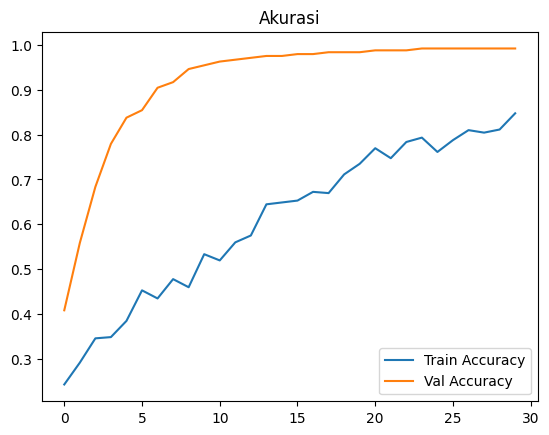

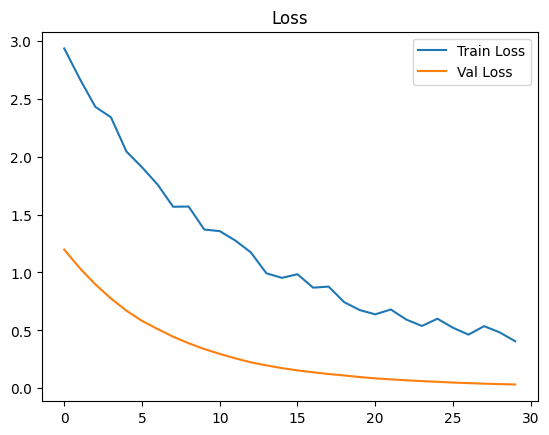

In [14]:
import matplotlib.pyplot as plt

# Akurasi
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Akurasi')
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


Found 240 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 465ms/step


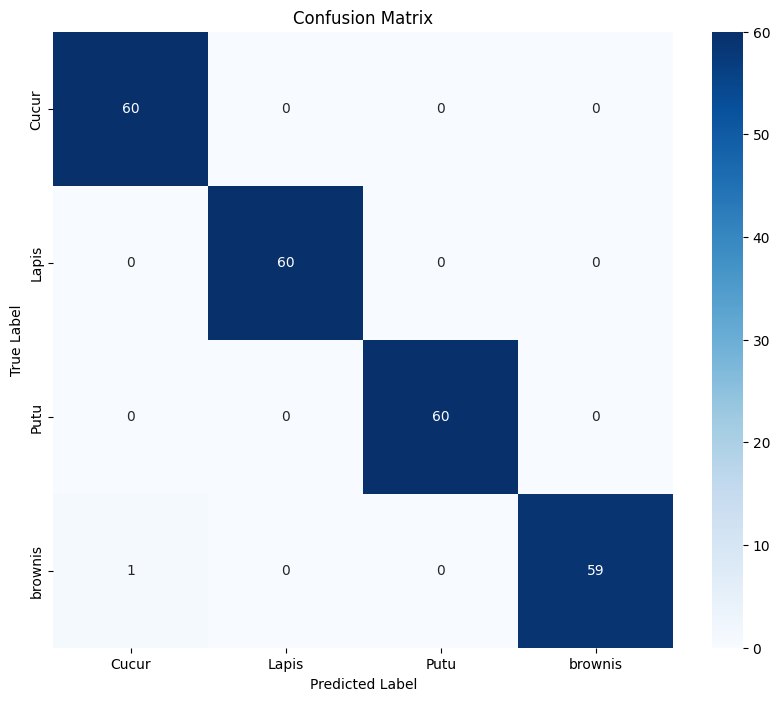

              precision    recall  f1-score   support

       Cucur       0.98      1.00      0.99        60
       Lapis       1.00      1.00      1.00        60
        Putu       1.00      1.00      1.00        60
     brownis       1.00      0.98      0.99        60

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Buat generator untuk test set (tanpa augmentasi, hanya rescale)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'data_split/test',  # ubah jika path test kamu beda
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # penting agar urutan label sama dengan prediksi
)

# 2. Prediksi
pred_probs = model.predict(test_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes

# 3. Label kelas
class_labels = list(test_generator.class_indices.keys())

# 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 5. Laporan klasifikasi
print(classification_report(y_true, y_pred, target_names=class_labels))
